In [407]:
import glob
# This file should run basically insta fast. Bad coding for sure 
# There is a place where i sometimes comment out lin/rbf/sigmoid stuff
# Dont do that, it really helps for some subjects. 
# Anything. Leave only linear. For fast testing of best features
# But dont do that either. 
import os
genSavePath = f"{os.getcwd()}/SavedResults/"
day = "22" # Which month and days result you want to visualize in table
month = 11

repetitionValue = 21
repetitionName =  "debugg"#  "udrli1feattestanglnoBC"  # "udrliplotnoAda3"  #  "udrlBC4CVTest" # 
#  "udrliplotnoAda3hyperparams" 
repetitionString = f"{repetitionValue}{repetitionName}"
curSavePath = f"{genSavePath}{day}-{month}-{repetitionString}/"
savedResults = glob.glob(curSavePath + "savedBest*")

saveTop = False
if saveTop:
    saveTopName = "top2udrli.npy"
else:
    saveTopName = None
topAmount = 20
skipSubjects = []
onlySignificant = True
minAcc = 0.0
print(len(savedResults))
print(len(savedResults)/9)


90
10.0


In [408]:
import pandas as pd
from array import ArrayType
from requests import delete
import numpy as np


nameDict = dict()
nrOfNames = 0
kernelDict = dict()
nrOfKernel = 0

currSeed = 0
currSubj = 0
combinationList = []

testInfoPerSubject = [None] * 10

results = []
for path in savedResults:
    results.append(np.load(path, allow_pickle=True))

subjectAmount = 10
    
for subject in results:
    currSubj = subject[1]
    testInfoPerSubject[currSubj] = subject[0]
soloFeatures = []
featCombos = []
kernels = testInfoPerSubject[1][2][0]
regValues = testInfoPerSubject[1][2][1]
paradigmName = testInfoPerSubject[1][3]
for subinfo in testInfoPerSubject[1:]:
    if subinfo is None:
        continue
    subSoloFeatures = subinfo[0]
    subfeatCombos = subinfo[1]
    if len(soloFeatures) < len(subSoloFeatures):
        soloFeatures = subSoloFeatures
    if len(featCombos) < len(subfeatCombos):
        featCombos = subfeatCombos
    #print(subinfo)
allCombinations = []
comboNumber = 0
combinationDict = dict()
for featCombo in featCombos:
    for kernel in kernels:
        for regValue in regValues:
            allCombinations.append([featCombo, kernel, regValue, comboNumber])
            combinationDict[f"{featCombo},{kernel},{regValue}"] = comboNumber
            comboNumber = comboNumber + 1
#print(combinationDict)
nrOfCombination = len(allCombinations)
combinationResult = np.zeros([subjectAmount, len(allCombinations), 2])
combinationAmounts = np.zeros([subjectAmount, len(allCombinations)])

nrOfSeedsPerSubject = np.zeros(subjectAmount)
seedCounted = np.zeros([subjectAmount, len(allCombinations), 20])
currSeed = -1
for s, subject in enumerate(results):
    currSubj = 0
    
    subjectBestArray = np.empty([len(subject)], dtype=object)

    
    currSubj = subject[1]
    # print(currSubj)
    # if currSubj == 1:
    #     currSeed = currSeed + 1 
    testInfoPerSubject[currSubj] = subject[0]
    if currSubj in skipSubjects:
        continue
    nrOfSeedsPerSubject[currSubj] += 1

    for aResults in subject[2]:
        for aResults2 in aResults:
            # If the np array comes from svm results
            if len(aResults2) < 10:
                
                aName = aResults2[0]
                ares = aResults2[1]
                akernel = aResults2[2]
 
                aC = aResults2[3]
               
                combinationResult[currSubj, combinationDict[f"{aName},{akernel},{aC}"]] = [int(combinationDict[f"{aName},{akernel},{aC}"]), 
                                                                                           combinationResult[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][1] + ares]
                # print(combinationDict[f"{aName},{akernel},{aC}"])

for subNr, subj in enumerate(combinationResult[1:], 1):
    combinationResult[subNr,:, 1] = combinationResult[subNr,:, 1] / nrOfSeedsPerSubject[subNr]
    if "adaBoost" in kernels or "MLP" in kernels:
        combinationResult[subNr,:, 1] = combinationResult[subNr,:, 1] / 2

combinationResult[combinationResult[:,:,1] > 1.001] = combinationResult[combinationResult[:,:,1] > 1.001] / 2
headers = np.arange(nrOfCombination)
subjectResultArray = np.empty([10, nrOfCombination], dtype=object)
subjectNrList = []

comboAverage = np.zeros([1, nrOfCombination])
comboTotal = np.zeros([1, nrOfCombination])
nrOfSubjects = np.zeros(nrOfCombination)

topTen = []
topThreeAllSubjects = []
topPerFeature = np.zeros([10, len(featCombos)])
allCombinations = np.array(allCombinations)
lowestTopRes = [0, 0]
for subNr, cResult in enumerate(combinationResult):
    topThreeThisSubject = []
    resArray = np.zeros([nrOfCombination])
    if len(cResult) != 0:
        for res in cResult:
            # print(res[0])
            cmbNr = int(res[0])
            # print(cmbNr)
            #print(cmbNr)
            if onlySignificant == True:
                if res[1] < minAcc:
                    continue
            comboAverage[0, cmbNr] = comboAverage[0, cmbNr] + res[1]
            comboTotal[0, cmbNr] = comboTotal[0, cmbNr] + res[1]
            nrOfSubjects[cmbNr] += 1
            subjectResultArray[subNr, cmbNr] = res[1]
            comboName = allCombinations[cmbNr][0]
            
            nameIndex = [i for i, elem in enumerate(featCombos) if comboName == elem][0]
            # print(comboName)
            #print(nameIndex)
            #print(featCombos[nameIndex])
   
            if res[1] > topPerFeature[subNr, nameIndex]:
                topPerFeature[subNr, nameIndex] = res[1]

            if len(topTen) < 10 or topTen[0][0] < res[1]:

                if len(topTen) == 10:
                    topTen.reverse()
                    topTen.pop()

                dataF = allCombinations[cmbNr][0]
                kernel =  allCombinations[cmbNr][1]
                cVal =  allCombinations[cmbNr][2]
                topTen.append([res[1], subNr, dataF, kernel, cVal])
                topTen.sort()
            
            if len(topThreeThisSubject) < 2 or topThreeThisSubject[0][0] < res[1]:

                if len(topThreeThisSubject) == 2:
                    topThreeThisSubject.reverse()
                    topThreeThisSubject.pop()
                dataF = allCombinations[cmbNr][0]
                kernel =  allCombinations[cmbNr][1]
                cVal =  allCombinations[cmbNr][2]
                topThreeThisSubject.append([res[1], subNr, dataF, kernel, cVal])
                topThreeThisSubject.sort()
    if len(topThreeThisSubject)>0:
        topThreeAllSubjects.append(topThreeThisSubject)
        
        
        
# Print the table!
comboAverage = comboAverage / nrOfSubjects
pd.set_option("display.max_columns", None)

# For loop through zip of headers and columns,
# If column has all values == None, Remove column and header.
subjectResultArray = np.array(subjectResultArray)
emptyCols = []
atleastOneEmpty = False
for hcol, in zip(headers):
    if all(subjectResultArray[:,hcol] == None):
        atleastOneEmpty = True
        emptyCols.append(hcol)
if atleastOneEmpty: 
    subjectResultArray = np.delete(subjectResultArray, np.array(emptyCols),1)
    headers = np.delete(headers, np.array(emptyCols),0)
    comboAverage = np.delete(comboAverage, np.array(emptyCols),1)
    comboTotal = np.delete(comboTotal, np.array(emptyCols),1)
    nrOfSubjects = np.delete(nrOfSubjects, np.array(emptyCols),0)


table = pd.DataFrame(subjectResultArray, columns=headers)
display(table)




/tmp/ipykernel_108082/2750671560.py:162: RuntimeWarning: invalid value encountered in true_divide
  comboAverage = comboAverage / nrOfSubjects


,0,6,7,8,9,10,11,12,13,14,15,16,17,18,24,25,26,27,28,29,30,31,32,33,34,35,36,42,43,44,45,46,47,48,49,50,51,52,53,54,60,61,62,63,64,65,66,67,68,69,70,71
0,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,0.0,0.2225,0.2225,0.225,0.215,0.2175,0.2175,0.225,0.205,0.2325,0.2175,0.2225,0.2075,0.2275,0.2725,0.2725,0.2775,0.2675,0.2675,0.2675,0.23,0.2325,0.2325,0.2275,0.225,0.2325,0.205,0.22,0.22,0.22,0.2225,0.215,0.215,0.215,0.215,0.215,0.215,0.2125,0.23,0.1925,0.2625,0.2625,0.2375,0.215,0.2025,0.2025,0.2175,0.2175,0.225,0.2225,0.22,0.205
2,0.0,0.185417,0.185417,0.185417,0.222917,0.220833,0.220833,0.208333,0.225,0.214583,0.214583,0.233333,0.227083,0.277083,0.297917,0.297917,0.289583,0.264583,0.258333,0.258333,0.2625,0.2625,0.2875,0.2625,0.2375,0.227083,0.222917,0.264583,0.264583,0.264583,0.266667,0.225,0.210417,0.2625,0.2625,0.2625,0.2625,0.252083,0.222917,0.214583,0.245833,0.245833,0.233333,0.222917,0.225,0.225,0.258333,0.258333,0.210417,0.23125,0.222917,0.214583
3,0.0,0.230556,0.230556,0.241667,0.252778,0.252778,0.252778,0.283333,0.277778,0.291667,0.305556,0.294444,0.288889,0.205556,0.15,0.15,0.147222,0.122222,0.116667,0.116667,0.183333,0.180556,0.183333,0.202778,0.177778,0.191667,0.25,0.236111,0.236111,0.236111,0.236111,0.233333,0.222222,0.233333,0.233333,0.233333,0.233333,0.233333,0.227778,0.269444,0.275,0.275,0.261111,0.255556,0.244444,0.244444,0.238889,0.233333,0.25,0.244444,0.269444,0.261111
4,0.0,0.245833,0.247917,0.247917,0.25,0.254167,0.254167,0.258333,0.260417,0.239583,0.260417,0.2625,0.254167,0.229167,0.23125,0.23125,0.20625,0.19375,0.202083,0.202083,0.214583,0.191667,0.210417,0.202083,0.214583,0.210417,0.272917,0.270833,0.270833,0.270833,0.270833,0.275,0.2625,0.272917,0.272917,0.272917,0.272917,0.277083,0.277083,0.214583,0.233333,0.233333,0.252083,0.239583,0.2375,0.2375,0.266667,0.260417,0.254167,0.247917,0.241667,0.21875
5,0.0,0.233333,0.233333,0.264583,0.241667,0.247917,0.245833,0.24375,0.25625,0.25,0.2375,0.264583,0.252083,0.227083,0.239583,0.239583,0.245833,0.260417,0.254167,0.254167,0.229167,0.2375,0.252083,0.247917,0.23125,0.2375,0.291667,0.247917,0.247917,0.252083,0.258333,0.2875,0.285417,0.239583,0.239583,0.239583,0.2375,0.266667,0.289583,0.20625,0.2,0.202083,0.208333,0.19375,0.185417,0.20625,0.20625,0.204167,0.177083,0.18125,0.2125,0.216667
6,0.0,0.218182,0.218182,0.263636,0.25,0.261364,0.261364,0.211364,0.238636,0.231818,0.234091,0.225,0.220455,0.240909,0.222727,0.222727,0.220455,0.2,0.188636,0.188636,0.263636,0.265909,0.229545,0.227273,0.222727,0.236364,0.261364,0.229545,0.229545,0.229545,0.234091,0.243182,0.25,0.231818,0.231818,0.231818,0.231818,0.225,0.229545,0.277273,0.234091,0.234091,0.225,0.254545,0.275,0.277273,0.306818,0.304545,0.297727,0.268182,0.281818,0.320455
7,0.0,0.241667,0.241667,0.24375,0.235417,0.233333,0.233333,0.279167,0.227083,0.258333,0.260417,0.2375,0.254167,0.229167,0.227083,0.227083,0.229167,0.245833,0.247917,0.247917,0.239583,0.235417,0.233333,0.233333,0.208333,0.227083,0.2625,0.25,0.25,0.25,0.25,0.260417,0.289583,0.25,0.25,0.25,0.25,0.2625,0.266667,0.25625,0.258333,0.258333,0.260417,0.272917,0.270833,0.270833,0.241667,0.245833,0.266667,0.258333,0.258333,0.252083
8,0.0,0.195,0.195,0.205,0.245,0.245,0.245,0.2175,0.2225,0.235,0.275,0.28,0.275,0.31,0.265,0.265,0.2875,0.315,0.32,0.32,0.275,0.26,0.265,0.295,0.3,0.2725,0.2775,0.235,0.235,0.235,0.24,0.2475,0.2525,0.2475,0.2475,0.2475,0.2475,0.2375,0.265,0.2,0.2325,0.2325,0.255,0.2375,0.24,0.24,0.245,0.25,0.245,0.24,0.21,0.2075
9,0.0,0.19375,0.19375,0.189583,0.177083,0.172917,0.172917,0.19375,0.197917,0.185417,0.195833,0.2,0.202083,0.260417,0.260417,0.260417,0.28125,0.3125,0.310417,0.310417,0.277083,0.254167,0.23125,0.247917,0.252083,0.266667,0.254167,0.235417,0.235417,0.235417,0.245833,0.254167,0.241667,0.2375,0.2375,0.2375,0.2375,0.239

In [409]:
pd.set_option("display.max_columns", None)
print()
nameDictNrs = np.ones([1, len(nameDict)])
nameDictNrs[0,:] = np.arange(len(nameDict)) * 3
table = pd.DataFrame(topPerFeature, columns=featCombos)
display(table)


,fftData,normDatacor1x1,stftData,stftData_CV
0,0.000000,0.000000,0.000000,0.000000
1,0.232500,0.277500,0.230000,0.262500
2,0.233333,0.297917,0.266667,0.258333
3,0.305556,0.205556,0.250000,0.275000
4,0.262500,0.231250,0.277083,0.266667
5,0.264583,0.260417,0.291667,0.216667
6,0.263636,0.265909,0.261364,0.320455
7,0.279167,0.247917,0.289583,0.272917
8,0.280000,0.320000,0.277500,0.255000
9,0.216667,0.312500,0.254167,0.275000


(4,)



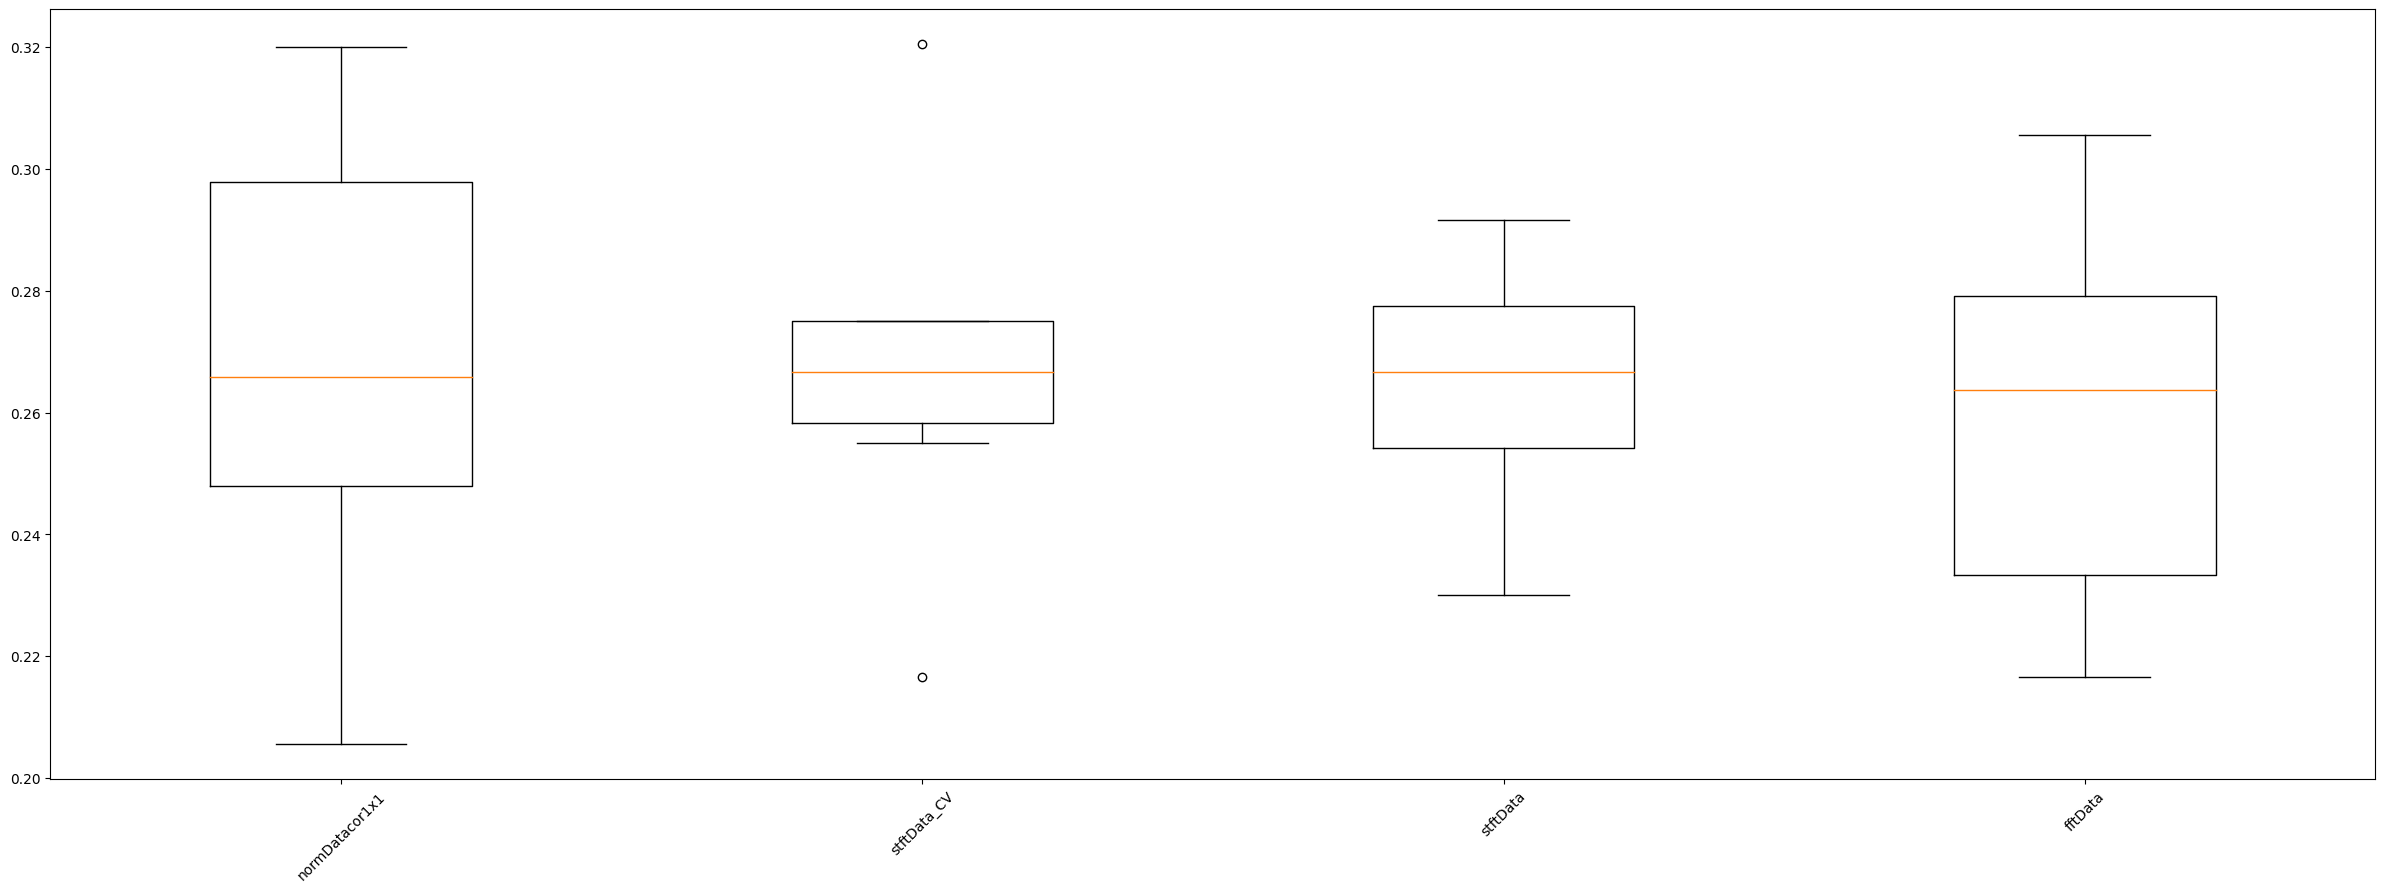

In [410]:
import matplotlib.pyplot as plt
meanTop = np.mean(topPerFeature[1:], axis=0)
indices = np.argsort(meanTop, axis=0)[::-1]

print(indices.shape)
featCombos = np.array(featCombos)

if len(featCombos) < 30:
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:30])
    plt.xticks(np.arange(len(featCombos[indices][:30]))+1,featCombos[indices][:30],rotation=45)
    print("")
else: 
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:30])
    plt.xticks(np.arange(30)+1,featCombos[indices][:30],rotation=90)
    print("")
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:10])
    plt.xticks(np.arange(10)+1,featCombos[indices][:10],rotation=20)
    print("")
    


In [411]:
print("Top ten highest accuracies")

topTen.reverse()
for top in topTen:
    print(
            f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
        )


Top ten highest accuracies
Accuracy 0.32 : subject 6, feature:stftData_CV, kernelsigmoid, C:10
Accuracy 0.32 : subject 8, feature:normDatacor1x1, kernelrbf, C:5
Accuracy 0.32 : subject 8, feature:normDatacor1x1, kernelrbf, C:10
Accuracy 0.32 : subject 8, feature:normDatacor1x1, kernelrbf, C:2.5
Accuracy 0.31 : subject 9, feature:normDatacor1x1, kernelrbf, C:2.5
Accuracy 0.31 : subject 9, feature:normDatacor1x1, kernelrbf, C:5
Accuracy 0.31 : subject 9, feature:normDatacor1x1, kernelrbf, C:10
Accuracy 0.31 : subject 8, feature:normDatacor1x1, kernellinear, C:0.1
Accuracy 0.31 : subject 6, feature:stftData_CV, kernelsigmoid, C:0.1
Accuracy 0.31 : subject 3, feature:fftData, kernelsigmoid, C:2.5


In [412]:
print("Top ten highest accuracies")
for subTop in topThreeAllSubjects:
    subTop.reverse()

Top ten highest accuracies


In [413]:
topThreeAllSubjects.sort(reverse=True)
arrayOfTopFeatureNames = []
for subTop in topThreeAllSubjects[:-1]:
    print("")
    for top in subTop[:1]:
        arrayOfTopFeatureNames.append(top[2])
        print(
                f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
            )

arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    if "_&_" in topNames:
        splitArray = np.array(topNames.split("_&_"), dtype=object)
    else: 
        splitArray = np.array(topNames, dtype=object)
    skip = False  
    
    newArrayOfTopFeatureNames.append(splitArray)
    
print(newArrayOfTopFeatureNames)
newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
if saveTopName is not None:
    np.save(f"topFeatures/{saveTopName}", newArrayOfTopFeatureNames)
    print("TopFeatureNameArraySaved")
    print(newArrayOfTopFeatureNames)



Accuracy 0.32 : subject 6, feature:stftData_CV, kernelsigmoid, C:10

Accuracy 0.32 : subject 8, feature:normDatacor1x1, kernelrbf, C:5

Accuracy 0.31 : subject 9, feature:normDatacor1x1, kernelrbf, C:2.5

Accuracy 0.31 : subject 3, feature:fftData, kernelsigmoid, C:2.5

Accuracy 0.3 : subject 2, feature:normDatacor1x1, kernelrbf, C:0.5

Accuracy 0.29 : subject 5, feature:stftData, kernellinear, C:0.1

Accuracy 0.29 : subject 7, feature:stftData, kernelrbf, C:10

Accuracy 0.28 : subject 1, feature:normDatacor1x1, kernelrbf, C:1.2

Accuracy 0.28 : subject 4, feature:stftData, kernelsigmoid, C:5
[array('stftData_CV', dtype=object), array('normDatacor1x1', dtype=object), array('normDatacor1x1', dtype=object), array('fftData', dtype=object), array('normDatacor1x1', dtype=object), array('stftData', dtype=object), array('stftData', dtype=object), array('normDatacor1x1', dtype=object), array('stftData', dtype=object)]


In [414]:
subjAv = np.zeros(subjectResultArray.shape[0])
for s, subj in enumerate(subjectResultArray):
    subjAv[s] = 0
    if all(subj == None):
        continue
    subjAv[s] = np.mean(subj[np.where(subj != None)])
print(subjAv)
pd.set_option("display.max_columns", None)
table = pd.DataFrame(np.array(comboAverage), columns=headers)
display(table)

print(
    f"Max average accuracy {np.max(np.array(comboAverage[np.where(np.isnan(comboAverage)==False)]))}"
)
maxVal = np.max(np.array(comboAverage[np.where(np.isnan(comboAverage) == False)]))
maxInd = int(np.where(comboAverage == maxVal)[1][0])



[0.         0.22240385 0.23613782 0.22494658 0.23946314 0.23289263
 0.23806818 0.24403045 0.24682692 0.23641827]


,0,6,7,8,9,10,11,12,13,14,15,16,17,18,24,25,26,27,28,29,30,31,32,33,34,35,36,42,43,44,45,46,47,48,49,50,51,52,53,54,60,61,62,63,64,65,66,67,68,69,70,71
0,0.008371,0.218471,0.218702,0.229617,0.232207,0.233979,0.233747,0.235614,0.234509,0.237656,0.244544,0.246651,0.242381,0.245209,0.24072,0.24072,0.242751,0.242423,0.240636,0.240636,0.241654,0.235579,0.236107,0.238478,0.229917,0.233531,0.255337,0.243267,0.243267,0.24373,0.247152,0.249011,0.247701,0.24335,0.24335,0.24335,0.243119,0.245139,0.250721,0.233987,0.244205,0.244436,0.242994,0.2389,0.23767,0.240237,0.246977,0.247125,0.24271,0.238671,0.242131,0.240776


Max average accuracy 0.25533670033670036


In [415]:
print("Based on combAverage")
#print(headers[comboAverage.argsort()[0][-5:][::-1]])
top5 = headers[comboAverage.argsort()[0][-5:][::-1]]
top5Vals = comboAverage[0][comboAverage.argsort()[0][-5:][::-1]]
for maxInd,res in zip(top5, top5Vals):
    #print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][1])
    print(res)
    print()

Based on combAverage
stftData
linear
0.25533670033670036

stftData
sigmoid
0.2507210998877666

stftData
rbf
0.24901094276094277

stftData
rbf
0.2477006172839506

stftData
rbf
0.247152076318743



In [416]:
print("Based on combTotal")
top5 = headers[comboTotal.argsort()[0][-5:][::-1]]
top5Vals = comboTotal[0][comboTotal.argsort()[0][-5:][::-1]] /9
for maxInd,res in zip(top5, top5Vals):
    print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][1])
    print(res)
    print()

Based on combTotal
stftData
linear
0.25533670033670036

stftData
sigmoid
0.2507210998877666

stftData
rbf
0.24901094276094277

stftData
rbf
0.2477006172839506

stftData
rbf
0.247152076318743



In [417]:
table = pd.DataFrame(np.array(comboTotal), columns=headers)
display(table)

maxVal2 = np.max(np.array(comboTotal[np.where(np.isnan(comboTotal) == False)]))

for maxInd2 in np.where(comboTotal == maxVal2)[1]:
    print(headers[maxInd2])
    print(nrOfSubjects[maxInd2])
    print(
        f"Max total significant accuracy then averaged {maxVal2/nrOfSubjects[maxInd2]} "
    )
    print(allCombinations[maxInd2][0])
    print(allCombinations[maxInd2][1])
    print(f"C: {allCombinations[maxInd2][2]} ")


,0,6,7,8,9,10,11,12,13,14,15,16,17,18,24,25,26,27,28,29,30,31,32,33,34,35,36,42,43,44,45,46,47,48,49,50,51,52,53,54,60,61,62,63,64,65,66,67,68,69,70,71
0,2.184899,1.966237,1.968321,2.066553,2.089861,2.105808,2.103725,2.12053,2.110581,2.138902,2.200896,2.219861,2.181427,2.206881,2.166477,2.166477,2.18476,2.181806,2.16572,2.16572,2.174886,2.120215,2.124962,2.146301,2.069255,2.10178,2.29803,2.189407,2.189407,2.193573,2.224369,2.241098,2.229306,2.190152,2.190152,2.190152,2.188068,2.20625,2.25649,2.105884,2.197841,2.199924,2.186944,2.150101,2.139028,2.162134,2.22279,2.224129,2.184394,2.148043,2.179179,2.166982


36
9.0
Max total significant accuracy then averaged 0.25533670033670036 
normDatacor1x1
rbf
C: 1.2 


In [418]:
for names in featCombos:
    print(names)



fftData
normDatacor1x1
stftData
stftData_CV
